In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 10})

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import het_white
from datetime import timedelta 
from dateutil.relativedelta import relativedelta
from calendar import monthrange

In [2]:
raw_data_path = "../data/raw"
preprocessed_data_path = "../data/preprocessed"
figure_path = "../figures"
results_path = "../results"

In [3]:
fitting_start = "2017-01-01"
fitting_end = "2023-01-01"
crisis_start = "2021-09-01"

abc = 'abcdefh'

# Prepare regression data

In [4]:
# Read preprocessed
df = pd.read_csv(os.path.join(preprocessed_data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'gas_to_electricity_public': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'real_wages':'wages',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia',
})

# Monthly averages
dfx_monthly = dfx.resample('m').mean()

dfx_monthly['slp'] = dfx['slp'].resample('m').agg(pd.Series.sum, skipna=False)
dfx_monthly['power'] = dfx['power'].resample('m').sum()
dfx_monthly['industry'] = dfx['industry'].resample('m').sum()
dfx_monthly['w2h'] = dfx['w2h'].resample('m').sum()

dfx_monthly['index']= dfx_monthly.index
dfx_monthly['time'] = range(len(dfx_monthly))
dfx_monthly['time'] = dfx_monthly['time'].apply(float)
dfx_monthly['month'] = dfx_monthly['index'].apply(lambda x: x.month)
dfx_monthly = dfx_monthly.drop(['weekday_num','monday','friday','weekend','christmas_period','holiday','long_weekend', 'index'], axis=1)

dfx[dfx.index < fitting_end
    ].rename(columns={'slp': 'consumption_small', 'industry': 'consumption_industry','power':'consumption_power','w2h':'heating_profiles','manu':'manufacturing_idx','hosp':'hospitality_idx','retail':'retail_idx','price_households':'price_households_idx','price_industry':'price_industry_idx','solar':'solar_radiation','temp':'temperature'}
    ).drop(['year','index','weekend','weekday_num','monday','friday'], axis=1
    ).to_csv(os.path.join(preprocessed_data_path, "dataset_daily.csv"))

dfx_monthly[dfx_monthly.index < fitting_end
    ].rename(columns={'slp': 'consumption_small', 'industry': 'consumption_industry','power':'consumption_power','w2h':'heating_profiles','manu':'manufacturing_idx','hosp':'hospitality_idx','retail':'retail_idx','price_households':'price_households_idx','price_industry':'price_industry_idx','solar':'solar_radiation','temp':'temperature'}
    ).drop(['year'], axis=1
    ).to_csv(os.path.join(preprocessed_data_path, "dataset_monthly.csv"))

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.long_weekend==0)
]

dfx_nocovid = dfx_monthly[(dfx_monthly.index < '2020-03-01')|(dfx_monthly.index >= '2021-03-01')].copy()

# Define functions

In [6]:
def model(
    dependent_variable,
    control_list,
    dataframe,
    no_trend: bool,
    fitting_end,
    fitting_start,
):
    if no_trend:
        if dataframe is dfx:
            m = f"{dependent_variable} ~ 1 + C(month) + C(weekday) + " + " + ".join(
                control_list
            )
        else:
            m = f"{dependent_variable} ~ 1 + C(month) +" + " + ".join(control_list)
    else:
        if dataframe is dfx:
            m = (
                f"{dependent_variable} ~ 1 + time + C(month) + C(weekday) + "
                + " + ".join(control_list)
            )
        else:
            m = f"{dependent_variable} ~ 1 + time + C(month) + " + " + ".join(
                control_list
            )

    return smf.ols(
        m,
        dataframe[
            (dataframe.index >= fitting_start) & (dataframe.index <= fitting_end)
        ],
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})


def all_models(
    dummy_list,
    consumer,
    econ=False,
    temp_sens=False,
    dataframe=dfx_monthly,
    daily_resolution=False,
    exclude_trend=False,
    exclude_covid=False,
):
    results = {}
    names = [
        "naive",
        "temp",
    ]
    if econ:
        names += ["temp+econ"]
    if temp_sens:
        names += ["temp+sens"]
    if exclude_trend:
        names += ["temp+no_trend"]
    if daily_resolution:
        names += ["temp+daily"]
    if exclude_covid:
        names += ["temp+no_covid"]
    if consumer == "power":
        names = ["naive"]
    for name in names:
        control_list = [d for d in dummy_list]
        if "temp" in name:
            control_list += ["w2h"]
        if "temp+sens" in name:
            control_list += ["solar", "temp"]
        if "econ" in name:
            control_list += (
                ["manu"] if consumer == "industry" else ["hosp", "retail", "wages"]
            )
        if "temp+no_trend" in name:
            no_trend = True
        else:
            no_trend = False
        if "temp+daily" in name:
            dataframe = dfx
        if "temp+no_covid" in name:
            dataframe = dfx_nocovid
        if "naive" in name:
            control_list = control_list
        results[name] = model(
            f"{consumer}", control_list, dataframe, no_trend, fitting_end, fitting_start
        )

    return results


def extract_results(
    dummy_list, results, normalize=False, daily_values=False, report_all=False
):

    extracted_results = pd.concat(
        [results.params, results.bse, results.pvalues], keys=["coef", "se", "p"], axis=1
    )
    if report_all == False:
        extracted_results = extracted_results.loc[[d + "[T.True]" for d in dummy_list]]
        extracted_results.index = dummy_list

    extracted_results["low"] = (
        extracted_results["coef"] - 1.96 * extracted_results["se"]
    )
    extracted_results["high"] = (
        extracted_results["coef"] + 1.96 * extracted_results["se"]
    )
    if normalize:
        fitted = results.fittedvalues
        if "crisis" in extracted_results.index:
            crisis_coeff = extracted_results.loc["crisis", "coef"]  # one_dummy
            ref = fitted[(fitted.index > crisis_start)].mean() - crisis_coeff
            extracted_results.loc["crisis"] = (
                extracted_results.loc["crisis"] / ref * 100
            )
        else:
            for year in [2021, 2022]:
                for month in range(1, 12 + 1):
                    try:
                        crisis_coeff = extracted_results.loc[
                            f"d{year}_{month}", "coef"
                        ]  # monthly model
                        ref = (
                            fitted[
                                (fitted.index > crisis_start)
                                & (fitted.index.month == month)
                                & (fitted.index.year == year)
                            ].mean()
                            - crisis_coeff
                        )
                        extracted_results.loc[f"d{year}_{month}"] = (
                            extracted_results.loc[f"d{year}_{month}"] / ref * 100
                        )
                    except KeyError:
                        pass
    elif daily_values:
        for i in dummy_list:
            if i != "crisis":
                extracted_results.loc[i] = (
                    extracted_results.loc[i]
                    * monthrange(int(i.split("_")[0][1:]), int(i.split("_")[1]))[1]
                )
            else:
                extracted_results.loc[i] = (
                    extracted_results.loc[i]
                    * len(pd.date_range(crisis_start, fitting_end, freq="1d"))
                    / len(pd.date_range(crisis_start, fitting_end, freq="1m"))
                )
    return extracted_results


def label(x: pd.Series) -> str:
    if x["p"] < 0.001:
        stars_number = 3
    elif x["p"] < 0.01:
        stars_number = 2
    elif x["p"] < 0.05:
        stars_number = 1
    else:
        stars_number = 0

    return f"{x['coef']}{'*'*stars_number} \n[{x['low']}, {x['high']}]"


def results_table(consumer, model_variant):
    results_table = pd.DataFrame(
        extract_results(dummy_list, results[consumer][model_variant], report_all=True)
    )
    results_table["join"] = round(results_table[["coef", "low", "high", "p"]], 3).apply(
        label, axis=1
    )
    return results_table.to_excel(
        results_path + f"/results_{consumer}_{model_variant}.xlsx"
    )


def curate_bars(results, consumer, model_variants):
    extracted_results = pd.concat(
        [
            extract_results(
                dummy_list,
                results[consumer][model_variant],
                daily_values=True if model_variant == "temp+daily" else False,
            )
            for model_variant in model_variants
        ],
        axis=1,
        keys=model_variants,
    )

    extracted_results.index = extracted_results.index.map(
        lambda x: pd.to_datetime(x.split("d")[1], format="%Y_%m")
        + relativedelta(months=+1)
        + timedelta(days=-1)
    )
    return extracted_results


def plot_bars(ax, df_all, consumer, model_variants, ylabel="", legend=False):
    idx = list(range(len(df_all)))
    df_models = df_all[consumer]
    # Legend
    if legend:
        if model_variants == ["temp"]:
            ax.fill_between(
                df_models.index,
                0,
                0,
                color=colors["naive"],
                alpha=0.4,
                label=names["naive"],
            )
        for model_variant in model_variants:
            ax.fill_between(
                df_models.index,
                0,
                0,
                color=colors[model_variant],
                alpha=0.4,
                label=names[model_variant],
            )
        # include percentage symbol in string
        ax.plot(0, 0, color="tab:grey", label=f"95% confidence interval")
        ax.legend(loc="lower left")
    # include percentage symbol in string
    for i, model_variant in enumerate(model_variants, 1):
        df = df_models[model_variant]
        width = 0.6 / len(model_variants)
        idx_mult = np.arange(len(df))
        # Bars
        ax.bar(
            (idx_mult - (len(model_variants) / 2 * width + width / 2) + i * width),
            df["coef"],
            width=width,
            alpha=0.5,
            label=title_conversion[consumer],
            color=colors[model_variant],
            align="center",
        )
        # Confidence intervals
        ax.plot(
            [
                (idx_mult - (len(model_variants) / 2 * width + width / 2) + i * width),
                (idx_mult - (len(model_variants) / 2 * width + width / 2) + i * width),
            ],
            [df["low"], df["high"]],
            color=colors[model_variant],
        )
    # Other things
    ax.grid(axis="y")
    ax.set_xlim(-0.5, len(idx) - 0.5)
    ax.set_title(title_conversion[consumer])
    # Labels of x axis
    start = df.index[0]
    end = df.index[-1]
    labels = [
        f"{date.month_name()[:3]}"
        + (f"\n{date.year}" if ((date.month == 1) | (i == 0)) else "")
        for i, date in enumerate(pd.date_range(start, end, freq="1m"))
    ]
    ax.set_xticks(range(len(labels)), labels)
    ax.set_ylim(df_all["slp"]["temp"]["low"].min() - 6.5, 4)
    ax.set_ylabel(ylabel)


def curate_lines(results, consumer, model_variant):
    model_results = results[consumer][model_variant]
    extracted_results = extract_results(dummy_list, model_results)["coef"]
    for i in dummy_list:
        if i != "crisis":
            int(i.split("_")[0][1:])
            int(i.split("_")[1])
    fitted_results = (
        model_results.fittedvalues.resample("M").mean().iloc[-len(extracted_results) :]
    )
    df = pd.DataFrame(index=fitted_results.index)
    df["Observed"] = fitted_results
    df["Estimated crisis response"] = extracted_results.values
    df["Estimated baseline"] = df["Observed"] - df["Estimated crisis response"]
    df["Estimated relative reduction"] = (
        df["Estimated crisis response"] / df["Estimated baseline"]
    )

    return df


def plot_lines(ax, df, consumer, model_variant, ylabel="", legend=False):
    df = df.copy()
    idx = range(len(df))
    # Legend
    if legend:
        ax.plot(0, 0, color="grey", label="Estimated baseline")
        ax.fill_between(
            idx,
            df["Observed"],
            df["Observed"],
            color="grey",
            alpha=0.4,
            label="Estimated crisis response",
        )
        ax.plot(0, 0, color="black", label="Observed")
        ax.plot(-1, 0, "o", color=colors["naive"], label=names["naive"])
        ax.plot(-1, 0, "o", color=colors["temp"], label=names["temp"])
        ax.legend(loc="upper right")
    # Lines
    ax.plot(
        idx,
        df["Estimated baseline"],
        color=colors[model_variant],
        label="Estimated baseline",
    )
    ax.fill_between(
        idx,
        df["Observed"],
        df["Estimated baseline"],
        color=colors[model_variant],
        alpha=0.4,
        label="Estimated crisis response",
    )
    ax.plot(idx, df["Observed"], color="black", label="Observed")
    # Percentage annotation
    df["idx"] = idx
    p_max = df.sort_values("Estimated relative reduction").iloc[0]
    ax.text(
        p_max["idx"] - 0.7,
        p_max["Estimated baseline"] + 3,
        f'{round(100*p_max["Estimated relative reduction"])}%',
        weight="bold",
    )
    p_last = df.iloc[-1]
    if p_last["idx"] != p_max["idx"]:
        ax.text(
            p_last["idx"] - 0.65,
            p_last["Estimated baseline"] + 3,
            f'{round(100*p_last["Estimated relative reduction"])}%',
        )
    # Other things
    ax.grid(axis="y")
    ax.set_xlim(-0.6, len(idx) - 0.4)
    ax.set_title(title_conversion[consumer])
    # Labels of x axis
    start = df.index[0]
    end = df.index[-1]
    labels = [
        f"{date.month_name()[:3]}"
        + (f"\n{date.year}" if ((date.month == 1) | (i == 0)) else "")
        for i, date in enumerate(pd.date_range(start, end, freq="1m"))
    ]
    ax.set_xticks(range(len(labels)), labels)
    ax.set_ylim(0, data_lines["slp"]["Observed"].max() + 15)
    ax.set_ylabel(ylabel)


def plot_residuals(ax, econ, consumer, dataframe=dfx_monthly):
    tick_spacing = 5
    mode = f'{"naive" if consumer == "power" else "temp"}'
    results_monthly = {
        consumer: all_models(
            dummy_list, consumer, econ=econ, temp_sens=False, dataframe=dataframe
        )
        for consumer in ["slp", "industry", "power"]
    }
    resid_month = (
        dataframe[consumer].resample("m").sum()
        - results_monthly[consumer][mode].fittedvalues.resample("m").sum()
    )
    monthly_coef = {
        m: extract_results(dummy_list, value, normalize=normalize)
        for m, value in results[consumer].items()
    }[mode]
    monthly_coef.index = monthly_coef.index.map(
        lambda x: pd.to_datetime(x.split("d")[1], format="%Y_%m")
        + relativedelta(months=+1)
        + timedelta(days=-1)
    )
    ax.grid()
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(title_conversion[consumer])
    resid_month.replace(np.nan, 0, inplace=True)
    ax.bar(
        resid_month.index,
        resid_month,
        width=-20,
        color="grey",
        label="Residuals",
        alpha=0.7,
        align="edge",
    )
    monthly_coef.index.freq = "m"
    ax.bar(
        monthly_coef.index,
        monthly_coef["coef"],
        width=-20,
        color=colors[mode],
        label="Estimated crisis response",
        alpha=0.7,
        align="edge",
    )
    for i, d in enumerate(monthly_coef.index):
        low = monthly_coef.loc[d, "low"]
        high = monthly_coef.loc[d, "high"]
        ax.plot(
            [d - timedelta(days=10), d - timedelta(days=10)],
            [high, low],
            color=colors[mode],
            linewidth=0.5,
        )
    ax.legend(loc="lower left")
    ax.set_ylabel("TWh")
    ax.set_ylim(monthly_coef["coef"].min() - 0.5, resid_month.max() + 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    fig.tight_layout()


def curate_scatter(results, consumer, model_variant):
    res = {}
    model_results = results[consumer][model_variant]
    for year in [2021, 2022]:
        for month in range(1, 12 + 1):

            try:
                crisis_coeff = model_results.params[f"d{year}_{month}[T.True]"]
                fitted = model_results.fittedvalues
                ref = (
                    fitted[
                        (fitted.index >= crisis_start)
                        & (fitted.index.month == month)
                        & (fitted.index.year == year)
                    ].mean()
                    - crisis_coeff
                )
                demand_response = crisis_coeff / ref * 100
                if consumer == "industry":
                    price_change = (
                        (
                            dfx["price_industry"][
                                (dfx.index.year == year) & (dfx.index.month == month)
                            ].mean()
                            - price_industry_precrisis
                        )
                        / price_industry_precrisis
                        * 100
                    )
                else:
                    price_change = (
                        (
                            dfx["price_households"][
                                (dfx.index.year == year) & (dfx.index.month == month)
                            ].mean()
                            - price_households_precrisis
                        )
                        / price_households_precrisis
                        * 100
                    )
                res[(year, month, "price change")] = price_change
                res[(year, month, "demand response")] = demand_response
            except KeyError:
                pass
    ds = pd.Series(res.values(), index=res.keys())

    return ds


def plot_scatter(ax: plt.Axes, df_all, consumer, ylabel, xlabel, one_legend=False):
    # sort values to get a smooth fit
    x = np.array(df_all["demand response"])
    y = np.array(df_all["price change"])
    x_prewar = np.array(df_all[df_all.index < "2022-03-01"]["demand response"])
    y_prewar = np.array(df_all[df_all.index < "2022-03-01"]["price change"])
    x_postwar = np.array(df_all[df_all.index >= "2022-03-01"]["demand response"])
    y_postwar = np.array(df_all[df_all.index >= "2022-03-01"]["price change"])
    ax.plot(x, y, linewidth=0.3, color="black")
    ax.scatter(x_prewar, y_prewar, s=15, color="tab:blue", label="Until Febuary 2022")
    ax.scatter(x_postwar, y_postwar, s=15, color="tab:orange", label="From March 2022")
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), color="tab:grey", linestyle="--", linewidth=1.5)
    ax.set_xlim(-30, 10)
    ax.set_ylim(-20, 600)
    ax.set_title(title_conversion[consumer])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if one_legend:
        if consumer == "industry":
            ax.legend()
        else:
            pass
    else:
        ax.legend()
    ax.grid()


def percent_changes(results):
    res = {}

    for con, mod in [("industry", "temp"), ("slp", "temp"), ("power", "naive")]:
        for year in [2021, 2022]:
            for month in range(1, 12 + 1):
                try:
                    crisis_coeff = results[con][mod].params[f"d{year}_{month}[T.True]"]
                    fitted = results[con][mod].fittedvalues
                    ref = (
                        fitted[
                            (fitted.index > crisis_start)
                            & (fitted.index.month == month)
                            & (fitted.index.year == year)
                        ].mean()
                        - crisis_coeff
                    )
                    coeff = round(crisis_coeff / ref * 100, 0)
                    res[(con, year, month)] = coeff

                except KeyError:
                    pass
    ds = pd.Series(res.values(), index=res.keys(), dtype=float)
    ds.index.names = ["type", "year", "month"]
    ds = ds.unstack("type")
    ds.index = pd.to_datetime(ds.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
    ds = ds.rename_axis("Date", axis=1)
    ds.columns = pd.MultiIndex.from_product([["Change in consumption (%)"], ds.columns])
    return ds


def absolute_changes(results):
    res = {}

    for con, mod in [("industry", "temp"), ("slp", "temp"), ("power", "naive")]:
        for year in [2021, 2022]:
            for month in range(1, 12 + 1):
                try:
                    crisis_coeff = results[con][mod].params[f"d{year}_{month}[T.True]"]
                    crisis_coeff = round(crisis_coeff, 2)
                    res[(con, year, month)] = crisis_coeff
                except KeyError:
                    pass
    ds = pd.Series(res.values(), index=res.keys(), dtype=float)
    ds.index.names = ["type", "year", "month"]
    ds = ds.unstack("type")
    ds["total"] = ds.sum(axis=1)
    ds.index = pd.to_datetime(ds.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
    ds = ds.rename_axis("Date", axis=1)
    ds.columns = pd.MultiIndex.from_product([["Absolute changes (TWh)"], ds.columns])
    return ds


def baseline(results):
    res = {}

    for con, mod in [("industry", "temp"), ("slp", "temp"), ("power", "naive")]:
        for year in [2021, 2022]:
            for month in range(1, 12 + 1):
                try:
                    crisis_coeff = results[con][mod].params[f"d{year}_{month}[T.True]"]
                    fitted = results[con][mod].fittedvalues
                    ref = (
                        fitted[
                            (fitted.index > crisis_start)
                            & (fitted.index.month == month)
                            & (fitted.index.year == year)
                        ].mean()
                        - crisis_coeff
                    )
                    ref = round(ref, 2)
                    res[(con, year, month)] = ref
                except KeyError:
                    pass
    ds = pd.Series(res.values(), index=res.keys(), dtype=float)
    ds.index.names = ["type", "year", "month"]
    ds = ds.unstack("type")
    ds["total"] = ds.sum(axis=1)
    ds.index = pd.to_datetime(ds.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
    ds = ds.rename_axis("Date", axis=1)
    ds.columns = pd.MultiIndex.from_product(
        [["Baseline consumption (TWh)"], ds.columns]
    )
    return ds


def elasticities(results, dfx=dfx_monthly):
    res = {}
    for con, mod in [("industry", "temp"), ("slp", "temp")]:
        for year in [2021, 2022]:
            for month in range(1, 12 + 1):
                try:
                    crisis_coeff = results[con][mod].params[f"d{year}_{month}[T.True]"]
                    fitted = results[con][mod].fittedvalues
                    ref = (
                        fitted[
                            (fitted.index > crisis_start)
                            & (fitted.index.month == month)
                            & (fitted.index.year == year)
                        ].mean()
                        - crisis_coeff
                    )
                    coeff = round(crisis_coeff / ref, 2) * 100
                    if con == "industry":
                        price_increase = (
                            (
                                dfx["price_industry"][
                                    (dfx.index.year == year)
                                    & (dfx.index.month == month)
                                ].mean()
                                - price_industry_precrisis
                            )
                            / price_industry_precrisis
                            * 100
                        )
                    else:
                        price_increase = (
                            (
                                dfx["price_households"][
                                    (dfx.index.year == year)
                                    & (dfx.index.month == month)
                                ].mean()
                                - price_households_precrisis
                            )
                            / price_households_precrisis
                            * 100
                        )
                    elasticity = round(coeff / price_increase, 2)
                    res[(con, year, month)] = elasticity
                except KeyError:
                    pass
    ds = pd.Series(res.values(), index=res.keys(), dtype=float)
    ds.index.names = ["type", "year", "month"]
    ds = ds.unstack("type")
    ds.index = pd.to_datetime(ds.index.map(lambda x: f"{x[0]}-{x[1]}-01"))
    ds = ds.rename_axis("Date", axis=1)
    ds.columns = pd.MultiIndex.from_product([["Elasticity"], ds.columns])
    return ds


def white_test(consumer, model_variant):
    test = het_white(
        results[consumer][model_variant].resid[
            results[consumer][model_variant].resid.index < crisis_start
        ],
        results[consumer][model_variant].model.exog[
            results[consumer][model_variant].resid.index < crisis_start
        ],
    )
    labels = [
        "Test Statistic",
        "Test Statistic p-value",
        "F-Statistic",
        "F-Test p-value",
    ]

    return print(
        f"White test for heteroscedasticity of residuals for specification: {consumer} / {model_variant}\n",
        dict(zip(labels, test)),
    )


# Main

In [7]:
colors = {
        'naive': 'tab:blue',
        'temp+econ':'tab:orange',
        'temp':'tab:red',
        'temp+sens':'tab:purple',
        'temp+no_trend':'tab:pink',
        'temp+daily':'tab:green',
        'temp+no_covid':'tab:cyan'
    }

names = {
        'naive':'Seasonally adjusted',
        'temp+econ':'Additional economic controls',
        'temp':'Seasonally and temperature-adjusted',
        'temp+sens':'Additional weather controls',
        'temp+no_trend':'Omitted time trend',
        'temp+daily':'Daily resolution',
        'temp+no_covid':'COVID-19 pandemic exluded'
}

title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',  
        'power':'Power sector',
        'w2h':'Simulated heating profiles' 
}

In [8]:
dummy_list = []
for date in pd.date_range(crisis_start, fitting_end, freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    
    dfx_monthly.loc[:,dummy_name] = dfx_monthly.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values

    dfx.loc[:,dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values

    dfx_nocovid.loc[:,dummy_name] = dfx_nocovid.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values

    dummy_list.append(dummy_name)

In [9]:
# Run regressions

log=False 
normalize=False
results = {consumer: all_models(dummy_list, consumer, econ=True, temp_sens=True, dataframe=dfx_monthly, exclude_trend=True, daily_resolution=True, exclude_covid=True) for consumer in ['slp', 'industry', 'power']}

### Figure 1: Prices of natural gas at the European wholesale and at the German retail market

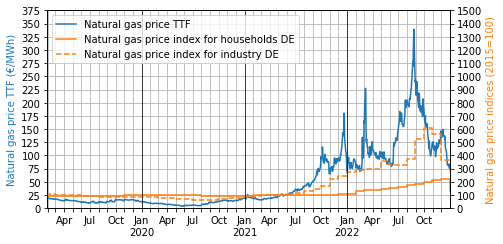

In [10]:
lang = 'EN'
fig = plt.figure(figsize=(7.08661, 3.5))

ax1 = fig.add_subplot(111)
plt.grid()

ax2 = ax1.twinx()

# Download historical TTF futures: https://www.investing.com/commodities/dutch-ttf-gas-c1-futures-historical-data
gas = pd.read_csv(os.path.join(raw_data_path, "Dutch TTF Natural Gas Futures Historical Data.csv"), index_col=0, sep=',')['Price']
gas.index = pd.to_datetime(gas.index)

handle1, = ax1.plot(gas.index, gas)
label1 = {'DE': 'Erdgaspreis TTF ', 'EN': 'Natural gas price TTF'}[lang]

ax1.set_ylabel(label1 + ' (€/MWh)',color='tab:blue')
ax1.set_ylim(0, 375)
ax1.set_yticks([x for x in range(0,375+25,25)])

dates = dfx_monthly.index
price_industry_plot = pd.concat([dfx_monthly['price_industry'],pd.concat([dfx_monthly['price_industry'][-1:]])])
price_industry_plot.index = dates.union(pd.date_range(dates[-1] + dates.freq, periods=1, freq=dates.freq))
price_households_plot = pd.concat([dfx_monthly['price_households'],pd.concat([dfx_monthly['price_households'][-1:]])])
price_households_plot.index = dates.union(pd.date_range(dates[-1] + dates.freq, periods=1, freq=dates.freq))

handle2, = ax2.step(price_households_plot.index, price_households_plot,color='tab:orange', where='post')
label2 = {'DE': 'Erdgaspreis für Haushalte DE', 'EN': 'Natural gas price index for households DE'}[lang]

handle3, = ax2.step(price_industry_plot.index, price_industry_plot, color='tab:orange', linestyle='--',where='post')
label3 = {'DE': 'Erdgaspreis für Industrie DE', 'EN': 'Natural gas price index for industry DE'}[lang]

ax2.set_ylabel('Natural gas price indices (2015=100)',color='tab:orange')
ax2.set_ylim(0, 1500)
ax2.set_yticks([x for x in range(0,1500+100,100)])

for year in range(2020, 2024):
    plt.axvline(pd.Timestamp(year,1,1), color='black', linewidth=0.7)

ax2.legend([handle1, handle2, handle3], [label1, label2, label3], loc='upper left')

xticks = pd.date_range('2019-01-01', '2023-01-01', freq='1m')
ax1.set_xticks(
    [pd.Timestamp(date.year, date.month, 1) for date in xticks], 
    [(f'{date.month_name()[:3]}' if date.month % 3 == 1 else '')
     +(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
     for i, date in enumerate(xticks)]
)
plt.xlim(xticks[0], xticks[-1])

plt.tight_layout()
plt.savefig(figure_path + '/figure_1.pdf', dpi=600)

In [11]:
sensitivities = ['temp','naive', 'temp+econ','temp+no_trend','temp+sens', 'temp+daily','temp+no_covid']
consumers = ['slp', 'industry', 'power']

data_bars_single = pd.concat(
    [curate_bars(results, consumer, model_variants) for (consumer, model_variants) in [
        ('slp', ['temp']), ('industry', ['temp']), ('power', ['naive'])
    ]], axis=1, keys=consumers
)

data_bars_mult_econ = pd.concat(
    [curate_bars(results, consumer, model_variants) for (consumer, model_variants) in
       list((consumer, sensitivities) for consumer in consumers[:-1])
    ], axis=1, keys=consumers
)

### Figure 2: Estimated monthly crisis response of natural gas consumption

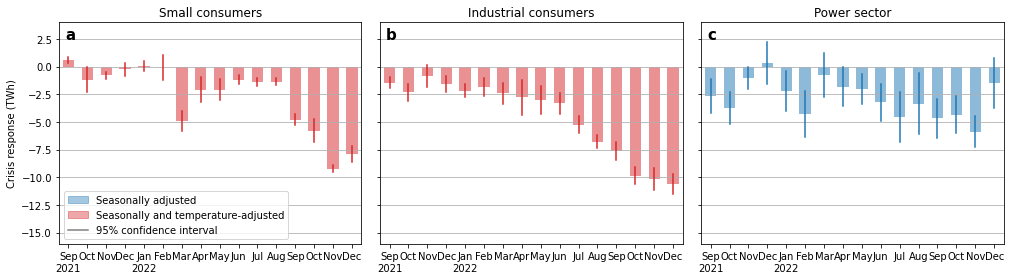

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.08661*2,4),sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_bars(ax1, data_bars_single, "slp", ["temp"], ylabel='Crisis response (TWh)', legend=True)
plot_bars(ax2, data_bars_single, "industry", ["temp"], ylabel='')
plot_bars(ax3, data_bars_single, "power", ["naive"], ylabel='')

for i, ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")  

plt.tight_layout()
plt.savefig(figure_path + '/figure_2.pdf', dpi=600)

In [13]:
data_lines = pd.concat(
    [curate_lines(results, consumer, model_variant) for (consumer, model_variant) in [
        ('slp', 'temp'), ('industry', 'temp'), ('power', 'naive')
    ]], axis=1, keys=['slp', 'industry', 'power']
)

### Figure 3: Observed versus estimated baseline consumption of natural gas

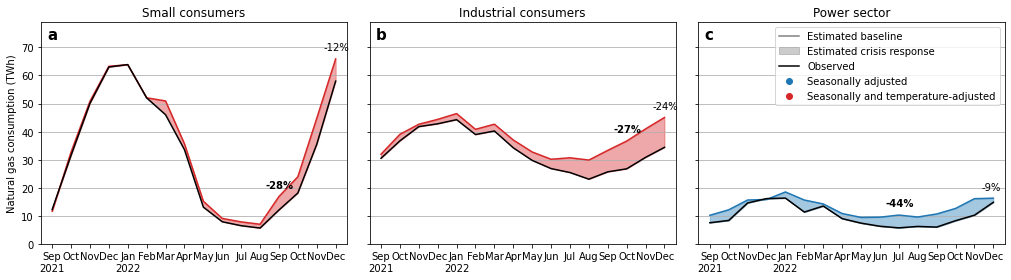

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.08661*2,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_lines(ax1, data_lines['slp'], 'slp', 'temp', ylabel='Natural gas consumption (TWh)')

plot_lines(ax2, data_lines['industry'], 'industry', 'temp')

plot_lines(ax3, data_lines['power'], 'power', 'naive', legend=True)

for i, ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")  

plt.tight_layout()
plt.savefig(figure_path + '/figure_3.pdf', dpi=600)

### Figure 4: Crisis response and price changes

In [15]:
price_households_precrisis = dfx['price_households'][(dfx.index < '2021-09-01')&(dfx.index.year >= 2019)].mean()
price_industry_precrisis = dfx['price_industry'][(dfx.index < '2021-09-01')&(dfx.index.year >= 2019)].mean()

In [16]:
data_scatter = pd.concat(
    [curate_scatter(results, consumer, model_variant).unstack(2) for (consumer, model_variant) in [
        ('slp', 'temp'), ('industry', 'temp'),
    ]], axis=1, keys=['slp', 'industry']
)

data_scatter.index = pd.date_range(start=crisis_start, end=fitting_end, freq='M')

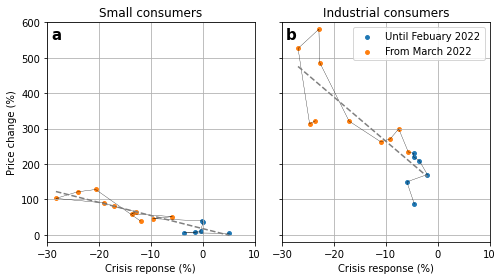

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.08661,4), sharey='row', gridspec_kw={'width_ratios': [1,1]})

plot_scatter(ax1, data_scatter['slp'], 'slp', ylabel='Price change (%)', xlabel='Crisis reponse (%)', one_legend=True)

plot_scatter(ax2, data_scatter['industry'], 'industry', ylabel='', xlabel='Crisis response (%)', one_legend=True)

for i, ax in enumerate([ax1,ax2]):
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")  

plt.tight_layout()
plt.savefig(figure_path + '/figure_4.pdf', dpi=600)

### Prices & elasticities

In [18]:
percent_changes(results)

Change in consumption (%)            
Date                        industry power   slp
2021-09-01                      -4.0 -26.0   5.0
2021-10-01                      -6.0 -31.0  -4.0
2021-11-01                      -2.0  -7.0  -1.0
2021-12-01                      -4.0   2.0  -0.0
2022-01-01                      -5.0 -12.0   0.0
2022-02-01                      -5.0 -27.0  -0.0
2022-03-01                      -6.0  -5.0 -10.0
2022-04-01                      -8.0 -17.0  -6.0
2022-05-01                      -9.0 -21.0 -14.0
2022-06-01                     -11.0 -33.0 -13.0
2022-07-01                     -17.0 -44.0 -17.0
2022-08-01                     -23.0 -35.0 -19.0
2022-09-01                     -23.0 -43.0 -28.0
2022-10-01                     -27.0 -34.0 -24.0
2022-11-01                     -25.0 -36.0 -21.0
2022-12-01                     -24.0  -9.0 -12.0

In [19]:
baseline(results)

Baseline consumption (TWh)                      
Date                         industry  power    slp   total
2021-09-01                      32.00  10.28  11.72   54.00
2021-10-01                      39.07  12.24  32.78   84.09
2021-11-01                      42.66  15.72  50.84  109.22
2021-12-01                      44.39  15.90  63.26  123.55
2022-01-01                      46.45  18.58  63.82  128.85
2022-02-01                      40.86  15.71  52.06  108.63
2022-03-01                      42.68  14.32  50.94  107.94
2022-04-01                      37.06  10.92  35.69   83.67
2022-05-01                      32.80   9.53  15.27   57.60
2022-06-01                      30.21   9.61   9.17   48.99
2022-07-01                      30.73  10.36   7.94   49.03
2022-08-01                      29.93   9.66   7.09   46.68
2022-09-01                      33.38  10.75  16.96   61.09
2022-10-01                      36.68  12.71  23.98   73.37
2022-11-01                      41.00  16.19  44.75  101.94
2022-12-01                      45.07  16.37  65.88  127.32

In [20]:
absolute_changes(results)

Absolute changes (TWh)                   
Date                     industry power   slp  total
2021-09-01                  -1.44 -2.64  0.61  -3.47
2021-10-01                  -2.32 -3.78 -1.18  -7.28
2021-11-01                  -0.85 -1.04 -0.76  -2.65
2021-12-01                  -1.57  0.32 -0.26  -1.51
2022-01-01                  -2.16 -2.18  0.05  -4.29
2022-02-01                  -1.86 -4.28 -0.04  -6.18
2022-03-01                  -2.42 -0.75 -4.90  -8.07
2022-04-01                  -2.78 -1.82 -2.08  -6.68
2022-05-01                  -3.00 -2.04 -2.09  -7.13
2022-06-01                  -3.31 -3.21 -1.19  -7.71
2022-07-01                  -5.25 -4.54 -1.36 -11.15
2022-08-01                  -6.80 -3.34 -1.35 -11.49
2022-09-01                  -7.64 -4.66 -4.80 -17.10
2022-10-01                  -9.87 -4.35 -5.78 -20.00
2022-11-01                 -10.12 -5.87 -9.23 -25.22
2022-12-01                 -10.63 -1.45 -7.90 -19.98

In [21]:
reduction_total = absolute_changes(results)[('Absolute changes (TWh)','total')] / baseline(results)[('Baseline consumption (TWh)','total')]*100

In [22]:
print('Highest relative reduction in total German gas consumption:', round(min(reduction_total),0),'%', f'in {reduction_total.idxmin().to_period("M")}')

Highest relative reduction in total German gas consumption: -28.0 % in 2022-09


In [23]:
print('Relative savings for H2 2022:', round((absolute_changes(results)[('Absolute changes (TWh)','total')][-6:].sum() / baseline(results)[('Baseline consumption (TWh)','total')][-6:].sum())*100,0),'%')

Relative savings for H2 2022: -23.0 %


In [24]:
elasticities(results)

Elasticity      
Date         industry   slp
2021-09-01      -0.05  1.30
2021-10-01      -0.04 -0.73
2021-11-01      -0.01 -0.14
2021-12-01      -0.02 -0.00
2022-01-01      -0.02  0.00
2022-02-01      -0.02 -0.00
2022-03-01      -0.03 -0.22
2022-04-01      -0.03 -0.12
2022-05-01      -0.03 -0.24
2022-06-01      -0.04 -0.20
2022-07-01      -0.05 -0.21
2022-08-01      -0.05 -0.21
2022-09-01      -0.04 -0.27
2022-10-01      -0.05 -0.20
2022-11-01      -0.08 -0.16
2022-12-01      -0.07 -0.31

In [25]:
print('Peak industry price increase (September 2022):',round((dfx['price_industry'][(dfx.index.year == 2022)&(dfx.index.month == 9)].mean() - price_industry_precrisis)/price_industry_precrisis*100,2),'%')
print('Peak household price increase (November 2022):',round((dfx['price_households'][(dfx.index.year == 2022)&(dfx.index.month == 11)].mean() - price_households_precrisis)/price_households_precrisis*100,2),'%')

Peak industry price increase (September 2022): 580.81 %
Peak household price increase (November 2022): 127.82 %


# Supplementary Information

## Main modeling results

In [26]:
#results tables are exported to xlsx file

results_table('industry','temp')
results_table('slp','temp')
results_table('power','naive')

## Supplementary Figure 1: Estimated crisis response and pre-crisis residuals 

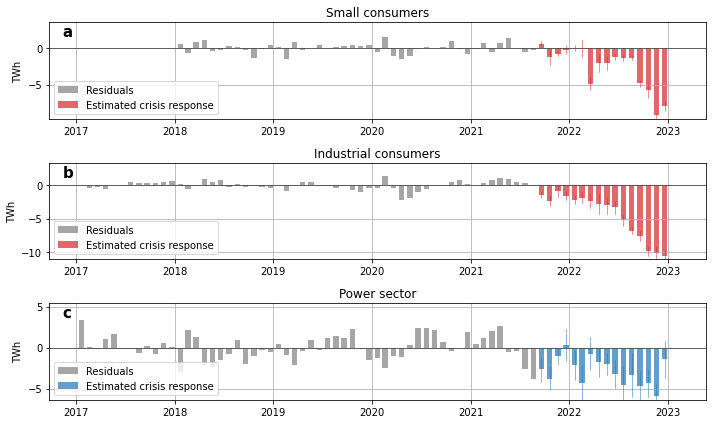

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,6), sharex='row')

plot_residuals(ax1, econ=False, consumer="slp", dataframe=dfx_monthly)
plot_residuals(ax2, econ=False, consumer="industry", dataframe=dfx_monthly)
plot_residuals(ax3, econ=False, consumer="power", dataframe=dfx_monthly)

for i, ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")  

plt.tight_layout()
plt.savefig(figure_path + '/si_figure_1.png', dpi=600)

## Supplementary Figure 2: Salience of energy topics throughout the crisis 

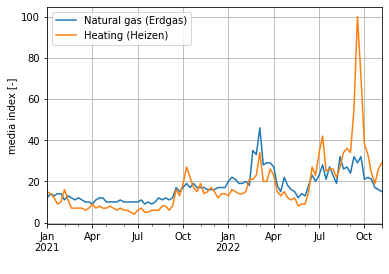

In [28]:
media = pd.read_csv(os.path.join(raw_data_path,'google_trends.csv'), skiprows=1, index_col=0)
media.columns  = ['Natural gas (Erdgas)', 'Heating (Heizen)']

media = media.apply(lambda col: 
    pd.to_numeric(col), axis = 1
)

media.index = pd.DatetimeIndex(media.index)
media.index.name = ' '

media.plot(ylabel = 'media index [-]')
plt.grid()

plt.savefig(figure_path + '/si_figure_2.png', dpi=600)

## Supplementary Figure 3: Sensitivity analyses

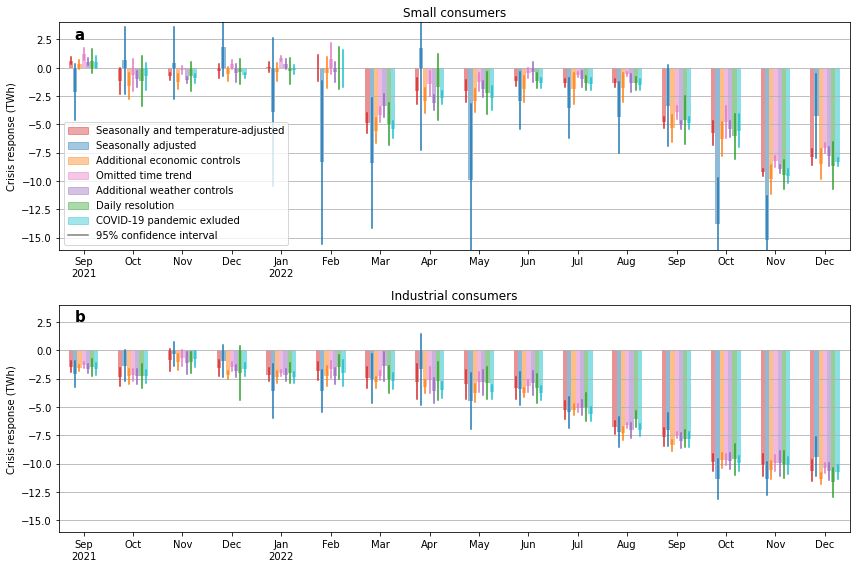

In [29]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8),sharey='row', gridspec_kw={'width_ratios': [1]})

plot_bars(ax1, data_bars_mult_econ, "slp", sensitivities, ylabel='Crisis response (TWh)', legend=True)

plot_bars(ax2, data_bars_mult_econ, "industry", sensitivities, ylabel='Crisis response (TWh)')

for i, ax in enumerate([ax1,ax2]):
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")  

plt.tight_layout()
plt.savefig(figure_path + '/si_figure_3.png', dpi=600)

## Supplementary Figure 4: Natural gas consumption by consumer group as well as simulated heating profiles

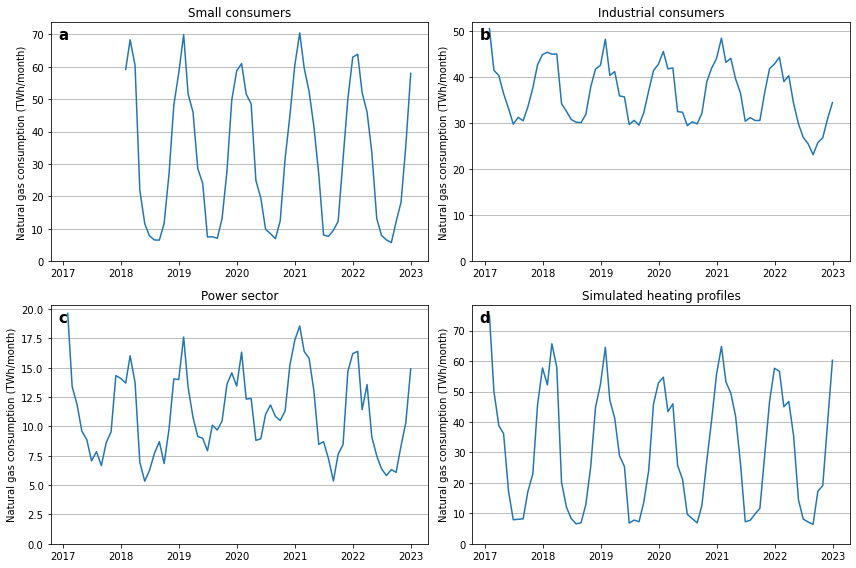

In [30]:
fig, axs = plt.subplots(2, 2,figsize=(12,8), sharex='row')

for ax, series in [(axs[0,0],'slp'),(axs[1,0],'power'),(axs[0,1],'industry'),(axs[1,1],'w2h')]:
    ax.plot(dfx_monthly[dfx_monthly.index < fitting_end][series].index, dfx_monthly[dfx_monthly.index < fitting_end][series])
    ax.set_title(title_conversion[series])
    ax.set_ylabel('Natural gas consumption (TWh/month)')
    ax.set_ylim(0)
    ax.grid(axis='y')

for i, ax in enumerate([axs[0,0],axs[0,1],axs[1,0],axs[1,1]]):
    
    ax.text(0.02, 0.98, abc[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")
    
plt.tight_layout()
plt.savefig(figure_path + '/si_figure_4.png', dpi=600)

## Statistical tests

In [31]:
residuals = {}

for dependent_variable in ["slp", "industry", "power", "w2h"]:

    residuals[dependent_variable] = (
        smf.ols(
            f"{dependent_variable} ~ 1 + C(month)",
            dfx_monthly[
                (dfx_monthly.index >= fitting_start) & (dfx_monthly.index < fitting_end)
            ],
        )
        .fit(cov_type="HAC", cov_kwds={"maxlags": 7})
        .resid
    )


### Augmented Dickey-Fuller test


In [32]:
for var in ['slp','industry','power','w2h']:

    print(f'{var} residuals \n', adfuller(residuals[var].dropna(), regression='ct'))

slp residuals 
 (-5.791175735948209, 5.9658690614939306e-06, 0, 59, {'1%': -4.121032198666855, '5%': -3.4877202932626994, '10%': -3.1721102476397296}, 268.7659842634124)
industry residuals 
 (-0.22348018036938191, 0.9911067241979848, 2, 69, {'1%': -4.096353737736257, '5%': -3.476155027137765, '10%': -3.165414996392793}, 215.5672807014472)
power residuals 
 (-4.6077983341570246, 0.0010004751659723542, 0, 71, {'1%': -4.092292635794932, '5%': -3.4742458957394433, '10%': -3.164308046274074}, 216.92015696226906)
w2h residuals 
 (-7.76174049803623, 2.5393237754904154e-10, 1, 70, {'1%': -4.094292755102041, '5%': -3.4751863673469385, '10%': -3.164853411078717}, 349.0166563271105)


### KPSS test


In [33]:
for var in ['slp','industry','power', 'w2h']:

    print(f'{var} residuals \n', kpss(residuals[var].dropna(), regression='c'))

slp residuals 
 (0.1588575829963046, 0.1, 1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
industry residuals 
 (0.5700123771344979, 0.025898113257995955, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
power residuals 
 (0.1906206704463343, 0.1, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
w2h residuals 
 (0.09096446856244014, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


c:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\c.stiewe\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### White test

In [34]:
white_test('slp','temp')
white_test('industry','temp')
white_test('power','naive')

White test for heteroscedasticity of residuals for specification: slp / temp
 {'Test Statistic': 43.189535873343644, 'Test Statistic p-value': 0.2591750910912784, 'F-Statistic': 7.011826286488796, 'F-Test p-value': 0.018943788933811753}
White test for heteroscedasticity of residuals for specification: industry / temp
 {'Test Statistic': 40.72614707089373, 'Test Statistic p-value': 0.35135965195091273, 'F-Statistic': 1.1928615651354897, 'F-Test p-value': 0.3573673347950476}
White test for heteroscedasticity of residuals for specification: power / naive
 {'Test Statistic': 36.861828919314235, 'Test Statistic p-value': 0.04516847780068887, 'F-Statistic': 2.4878655064118824, 'F-Test p-value': 0.008881024047797966}
